In [86]:
import cvxpy as cp
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

# Control with moment/stochastic relaxation for fixed-point escape

In this notebook, we study the control problem
$$
\begin{align}
	\mathrm{minimize}_{(\mathbb{P}_u)} ~&~ \mathbb{E} \frac{1}{N}\sum_{k=0}^{N-1} \begin{pmatrix}
		1\\
		x_k\\
		u_k
	\end{pmatrix}^\top R
	\begin{pmatrix}
		1\\
		x_k\\
		u_k
	\end{pmatrix} \hspace{4cm} (1)\\
	\mathrm{s.t.} ~&~ x_{k+1} = f + A x_k + B u_k + w_k\\
	~&~ \mathbb{E} \begin{pmatrix}
		1\\
		x_k\\
		u_k
	\end{pmatrix}^\top H_{i}
	\begin{pmatrix}
		1\\
		x_k\\
		u_k
	\end{pmatrix} \leq 0 \quad i = 1,\ldots,s \label{eq:timeVaryingProblem3}\\
    ~&~ u_k \sim \mathbb{P}_u\\
    ~&~ w_k \sim \mathbb{P}_w\\
	~&~ x_0 \sim \mathbb{P}_{x_0}\\
    ~&~ \mathbb{E} u_k u_k^\top - \mathbb{E} u_k x_k^\top (\mathbb{E} x_k x_k^\top)^{-1} \mathbb{E} x_ku_k^\top \succeq \Sigma_{v\min}
\end{align}
$$
In this control problem, $A \in \mathbb{R}^{n\times n}$ and $B \in \mathbb{R}^{n\times m}$ are system matrices of a linear dynamical system with an additional affine term $f$. Accordingly, we interprete the variable $x_k$ as the state, $u_k$ as a control input and $w_k$ as a disturbance input. The variables $x_0$ and $w_k$ for $k = 0,\ldots,N-1$ are distributed according to the random distributions $\mathbb{P}_{x_0}$ and $\mathbb{P}_{w_k}$ for $k \in\mathbb{N}_0$. These distributions are assumed to be independent. The disturbance distributions are additionally assumed to be zero mean. The control input $u_k$ is assumed to be distributed according to the random distribution $\mathbb{P}_{u_k}$, which, given $x_k$ is conditionally independent from all other random distributions. Due to these random distributions, the states $x_k$, inputs $u_k$, and disturbances $w_k$ are all random variables. The distributions $\mathbb{P}_{u_k}$ are interpreted as control policies and, therefore, are the decision variables of this dynamic program. The matrices $H_{i}$ and $R$ for $i = 1,\ldots,s$ are assumed to be symmetric and possibly indefinite. Finally, $\mathbb{E} u_k u_k^\top - \mathbb{E} u_k x_k^\top (\mathbb{E} x_k x_k^\top)^{-1} \mathbb{E} x_ku_k^\top \succeq \Sigma_{v\min}$ is a minimum excitation constraint making sure that the input $u_k$ incorporates an excitation component with at least variance $\Sigma_{v\min}$.

Because $H_{i}$ and $R$ are indefinite, this optimization problem could not be easily convexified if we would consider it as a deterministic dynamic program. As a stochastic dynamic program, however, where we minimize only the expectation value of the cost function and require constraint satisfaction only in the expectation value, it has been shown in the article ... that this dynamic program is equivalent to the semi-definite program
$$
\begin{align}
	\mathrm{minimize}_{(\Sigma)} ~&~ \mathrm{trace} \Sigma R \label{eq:timeVaryingSynthesis}\\
	\mathrm{s.t.} ~&~ \sigma^{11} = 1 \nonumber\\
	~&~ \widetilde{F}(\Sigma,\Sigma,\Sigma^w) = 0 \nonumber\\
	~&~ \mathrm{trace} \Sigma H_{i} \leq 0 & i = 1,\ldots,s\nonumber\\
	~&~ \Sigma \succeq \begin{pmatrix} 0 & 0 & 0\\ 0 & 0 & 0\\ 0 & 0 & \Sigma_{v\min} \end{pmatrix}. \nonumber
\end{align}
$$
In this semi-definite program the decision variables, i.e., the matrix
$$
\begin{align}
	\Sigma_k =
	\begin{pmatrix}
		\sigma^{11} & \sigma^{12} & \sigma^{13}\\
		\sigma^{21} & \Sigma^{22} & \Sigma^{23}\\
		\sigma^{31} & \Sigma^{32} & \Sigma^{33}
	\end{pmatrix}
	:=
	\mathbb{E} \frac{1}{N}\sum_{k=0}^{N-1} \begin{pmatrix}
		1\\
		x_k\\
		u_k
	\end{pmatrix}
	\begin{pmatrix}
		1\\
		x_k\\
		u_k
	\end{pmatrix}^\top . \label{eq:momentEquation}
\end{align}
$$
is the average moment matrix of the state $x_k$ and the input $u_k$. The moment matrix average moment matrix of the disturbances $\Sigma^w_k = \mathbb{E} \frac{1}{N}\sum_{k=0}^{N-1} w_k w_k^\top$, on the other hand, is assumed to be fixed and known. If an optimal solution to this semi-definite program in the form of an average moment matrices can be obtained, then this enables the extraction of an optimal policy $\mathbb{P}_{u_k}$. This policy can be expressed by defining the random variable $u_k$ as
$$
\begin{align}
		u_k &= \begin{pmatrix}
			\sigma^{31} & \Sigma^{32}
		\end{pmatrix}
		\begin{pmatrix}
			\sigma^{11} & \sigma^{12}\\
			\sigma^{21} & \Sigma^{22}
		\end{pmatrix}^{-1}
		\begin{pmatrix}
			1\\ x_k
		\end{pmatrix} + v_k & v_k \sim \mathbb{P}_v, \label{eq:controllerReconstruction}
	\end{align}
$$
where $\mathbb{P}_v$ is the distribution of some random variable $v_k$, which is zero mean, has the second moment
$$
\begin{align}
		\Sigma_v := \Sigma^{33} - \begin{pmatrix}
			\sigma^{31} & \Sigma^{32}
		\end{pmatrix}
		\begin{pmatrix}
			\sigma^{11} & \sigma^{12}\\
			\sigma^{21} & \Sigma^{22}
		\end{pmatrix}^{-1} \begin{pmatrix}
			\sigma^{13}\\
			\Sigma^{23}
		\end{pmatrix} \succeq \Sigma_{v\min}
	\end{align}
$$
and is stochastically independent from $x_0$ and $w_k$ for $k = 0,\ldots, N-1$.


In this notebook we show how the above controller design strategy can be utilized to design a swing up controller for an inverted pendulum using cvxpy and Mosek. We start of by defining a routine for solving the controller synthesis problem.

In [551]:
def timeInv_stateSpace(f,A,B,R,H,SigmaW,SigmaVmin):
    # Extract problem dimensions
    (n,m) = B.shape
    s = len(H)
    
    # Define the decision variables
    Sigma = cp.Variable((1+n+m,1+n+m),symmetric = True)
    constraints = [Sigma >> + np.block([[np.zeros((1+n,1+n+m))],[np.zeros((m,1+n)),SigmaVmin]]),Sigma[0,0] == 1]
    
    # Constraint (1)
    temp = np.block([[np.ones((1,1)), np.zeros((1,n+m))],
                         [f,A,B]])
    constraints += [Sigma[0:1+n,0:1+n] == temp@Sigma@temp.T + np.block([[np.zeros((1,1+n))],[np.zeros((n,1)),SigmaW]])]
    
    # Constraint (2)
    for i in range(s):
        constraints += [cp.trace(Sigma@H[i]) <= 0]
    
    # Call the solver
    nu = cp.trace(Sigma@R)
    prob = cp.Problem(cp.Minimize(nu),constraints)
    prob.solve(solver = "MOSEK",verbose = True)
    # Reconstruct the controller
    
    K = np.linalg.solve(Sigma[0:1+n,0:1+n].value,Sigma[0:1+n,1+n:1+n+m].value).T
    SigmaV = Sigma[1+n:1+n+m,1+n:1+n+m].value - Sigma[1+n:1+n+m,0:1+n].value @ K.T
    nu = nu.value
    Sigma = Sigma.value
    return (K,SigmaV,nu,Sigma)

## Swing up controller for an inverted pendulum

In the present notebook we design a swing up controller for an inverted pendulum.

The equations of motion of an inverted pendulum can be described by
$$
\begin{align}
    (M+m)\ddot{x} + ml \ddot{\theta} \cos \theta - ml\dot{\theta}^2\sin \theta &= F\\
    l\ddot{\theta} + g \sin \theta = -\ddot{x} \cos \theta
\end{align}
$$
or equivalently
$$
\begin{align}
    \ddot{x} &= \frac{-mg\sin \theta \cos \theta + ml\dot{\theta}^2\sin\theta + u}{M + (\sin\theta)^2 m}\\
    \ddot{\theta} &= \frac{(ml\dot{\theta}^2 \cos \theta - (M+m)g)\sin \theta - (l\cos\theta)u}{l(M + (\sin\theta)^2 m)}.
\end{align}
$$
Here, $\theta = 0$ is the lower pendulum position.

For given $M, m$ and $l$, are implemented as a function in the following.

In [602]:
M = 1 #kg
m = 0.001 #kg
g = 9.81 #N/kg
l = 0.5 #m

def fun(x,u):
    dotx = np.zeros(x.shape)
    dotx[0] = x[2]
    dotx[1] = x[3]
    massMatrix = np.array([[M+m,m*l*np.cos(x[1])],[m*l*np.cos(x[1]),m*l*l]])
    rhs = np.block([[m*l*x[3]*x[3]*np.sin(x[1]) + u],[-g*l*m*np.sin(x[1])]])
    dotx[2:] = np.linalg.solve(massMatrix,rhs)[:,0]
    return dotx

# define the discrete dynamics via Euler discretization
h = 0.01 #s (step size)
def F(x,u):
    return x + h*fun(x,u)

Our strategy for carrying out the swing up is based on the design of two linear stochastic controllers using the controller design problem (1).
- The first controller has the objective to swing the pendulum sufficiently high to enable the stabilization of the upper equilibrium by a second controller (escape from the lower equilibrium).
- The second controller has the objective to stabilize the upper equilibrium once the pendulum is sufficiently high.

For the design of the first controller, we linearize the dynamics in the lower fixed point and choose the objective to minimize
$$
    \lim_{N\to\infty} \mathbb{E} \frac{1}{N}\sum_{t=0}^N 100 x_1^2 + 10x_3^2 - 10^4 \frac{1}{2}(mlg x_2^2 + ml^2 x_4^2) + u^2.
$$
Particularly, we maximize the pendulum energy $\frac{1}{2}(mlg x_2^2 + ml^2 x_4^2)$. To make sure that the states do not become unbounded, we include the additional constraint $\mathbb{E} \frac{1}{2}(mlg x_2^2 + ml^2 x_4^2) \leq mlg$, which constrains the expectation value of the pendulum energy.

In [611]:
f = np.zeros((4,1))

massMatrix = np.array([[M+m,m*l],[m*l,m*l*l]])
pA = np.linalg.solve(massMatrix,np.array([[0],[-g*l*m]]))
pB = np.linalg.solve(massMatrix,np.array([[1],[0]]))
A = np.array([[0,0,1,0],
              [0,0,0,1],
              [0,pA[0,0],0,0],
              [0,pA[1,0],0,0]])
B = np.array([[0],[0],[pB[0,0]],[pB[1,0]]])
A = np.identity(4) + h*A
B = h*B

R = np.zeros((6,6))
R[1,1] = 100
R[2,2] = -(1e5) *m*l*g/2
R[3,3] = 10
R[4,4] = -(1e5) *m*l*l/2
R[5,5] = 1

H = np.zeros((6,6))
H[0,0] = -m*l*g
H[2,2] = 0.5*m*l*g
H[4,4] = 0.5*m*l*l
H = [H]

SigmaW = np.zeros((4,4))
SigmaVmin = np.array([[(10**3)*h]])

Notice that we incorporate $\Sigma_{v\min} > 0$. That is because the pendulum conserves energy. Hence, the optimal solution with $\Sigma_{v\min} = 0$ would simply be an equilibrium distribution with energy $mlg$ and no control effort being spent. However, we want to design a solution where the controller excites the plant to stabilize a control energy of $mlg$. Hence, we set a minimum excitation value of $\Sigma_{v\min} > 0$.

Next, we design the first (escape) controller.

In [612]:
(K1,SigmaV1,nu1,Sigma1) = timeInv_stateSpace(f,A,B,R,H,SigmaW,SigmaVmin)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Mar 21 02:41:20 PM: Your problem has 36 variables, 4 constraints, and 0 parameters.
(CVXPY) Mar 21 02:41:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 21 02:41:20 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 21 02:41:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 21 02:41:20 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Mar 21 02:41:20 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

(CVXPY) Mar 21 02:41:21 PM: Solver (including time spent in interface) took 1.020e-01 seconds


In addition to the escape controller, we require a second controller to stabilize the pendulum in its top position. For this controller, we choose the cost function
$$
    \lim_{N\to\infty} \mathbb{E} \frac{1}{N}\sum_{t=0}^N 100 x_1^2 + 10x_3^2 + x_2^2 + x_4^2 + u^2
$$
and no constraints. However, we set $\Sigma^w = I$ to make sure we do not obtain the zero solution.

In [634]:
f = np.zeros((4,1))

massMatrix = np.array([[M+m,-m*l],[-m*l,m*l*l]])
pA = np.linalg.solve(massMatrix,np.array([[0],[g*l*m]]))
pB = np.linalg.solve(massMatrix,np.array([[1],[0]]))
A = np.array([[0,0,1,0],
              [0,0,0,1],
              [0,pA[0,0],0,0],
              [0,pA[1,0],0,0]])
B = np.array([[0],[0],[pB[0,0]],[pB[1,0]]])
A = np.identity(4) + h*A
B = h*B

R = np.zeros((6,6))
R[1,1] = 100
R[2,2] = 1
R[3,3] = 10
R[4,4] = 1
R[5,5] = 1

H = []

SigmaW = np.identity(4)
SigmaVmin = np.array([[0]])

In [635]:
(K2,SigmaV2,nu2,Sigma2) = timeInv_stateSpace(f,A,B,R,H,SigmaW,SigmaVmin)

P2 = np.linalg.inv(Sigma2[1:n+1,1:n+1]) # x' P2 x is a Lyapunov function for K2

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Mar 21 02:47:51 PM: Your problem has 36 variables, 3 constraints, and 0 parameters.
(CVXPY) Mar 21 02:47:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 21 02:47:51 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 21 02:47:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 21 02:47:51 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Mar 21 02:47:51 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

In [715]:
# array for trajectories
x_array = []
u_array = []
N = 5000

num_traj = 2
np.random.seed(22)
xbar = np.zeros((4,1))

t_controller1 = [[0] for i in range(num_traj)]
t_controller2 = [[] for i in range(num_traj)]

for i in range(num_traj):
    x = np.zeros((4,N+1))
    u = np.zeros((1,N))
    x[:,0] = xbar[0:,0]
    for t in range(N):
        v = np.random.choice([-1,1],size = (1,1))
        x_controller1 = np.array([x[0,t:t+1],np.mod(x[1,t:t+1]+np.pi,2*np.pi)-np.pi,x[2,t:t+1],x[3,t:t+1]]) #choose the right point for the linearization of the first controller modulo 2\pi
        x_controller2 = np.array([x[0,t:t+1],np.mod(x[1,t:t+1],2*np.pi)-np.pi,x[2,t:t+1],x[3,t:t+1]]) #choose the right point for the linearization of the second controller modulo 2\pi
        if x_controller2.T @P2 @ x_controller2 <= 0.02:
            u[:,t:t+1] = K2@np.vstack([np.ones((1,1)),x_controller2])
            t_controller2[i].append(t+1)
        else:
            u[:,t:t+1] = K1@np.vstack([np.ones((1,1)),x_controller1]) + np.sqrt(SigmaV)*v
            t_controller1[i].append(t+1)
        x[:,t+1] = F(x[:,t],u[:,t])
    x_array += [x]
    u_array += [u]

C:\Users\Deniss Grammel\AppData\Local\Temp\ipykernel_28044\1738281226.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
C:\Users\Deniss Grammel\AppData\Local\Temp\ipykernel_28044\1738281226.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


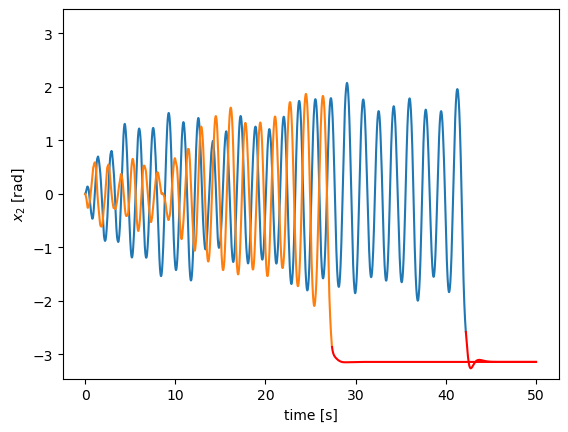

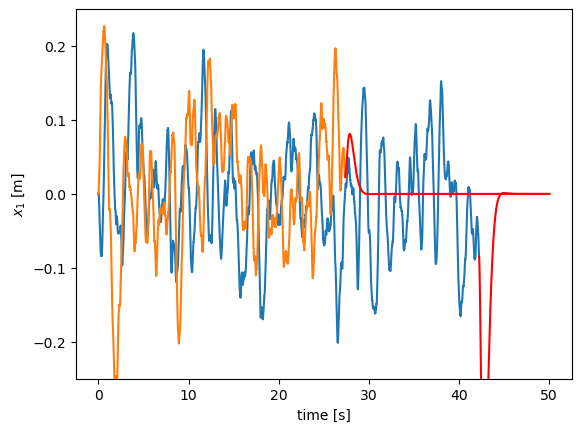

In [716]:
import tikzplotlib
fig1, ax1 = plt.subplots()
time = np.linspace(0,N*h,N+1)
for i in range(num_traj):
    x = x_array[i]
    ax1.plot(time[t_controller1[i]],x[1,t_controller1[i]])
    ax1.plot(time[t_controller2[i]],x[1,t_controller2[i]],'r')


ax1.set_ylim([-1.1*np.pi,1.1*np.pi])
ax1.set_xlabel('time [s]')
ax1.set_ylabel('$x_2$ [rad]')
fig1.show()
tikzplotlib.save("angle.tex")

fig2, ax2 = plt.subplots()
for i in range(num_traj):
    x = x_array[i]
    ax2.plot(time[t_controller1[i]],x[0,t_controller1[i]])
    ax2.plot(time[t_controller2[i]],x[0,t_controller2[i]],'r')


ax2.set_ylim([-0.25,0.25])
ax2.set_xlabel('time [s]')
ax2.set_ylabel('$x_1$ [m]')
fig2.show()
tikzplotlib.save("sled_pos.tex")

We mention that for different random seeds, the pendulum might actually be stabilized at a different equilibrium. Recall that the pendulum has an equilibrium for any angle $\theta = k\pi$ with $k \in \mathbb{Z}$. Due to the modulo operation in the code, also other equilibria could be stabilized.

Next, let us check what happens if we perturb the initial condition. After all, we have designed a feedback strategy for the swing up, which should be robust to different initial conditions.

C:\Users\Deniss Grammel\AppData\Local\Temp\ipykernel_28044\3930273533.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
C:\Users\Deniss Grammel\AppData\Local\Temp\ipykernel_28044\3930273533.py:55: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


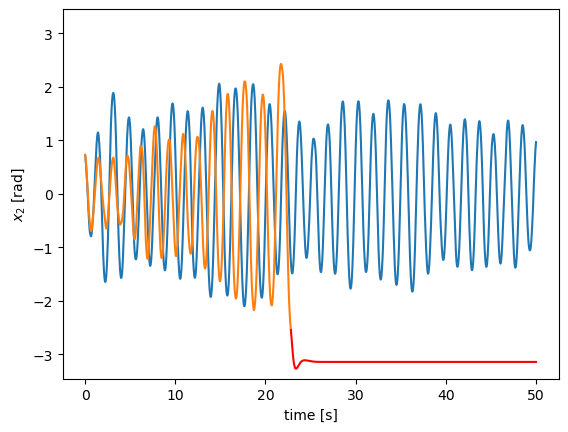

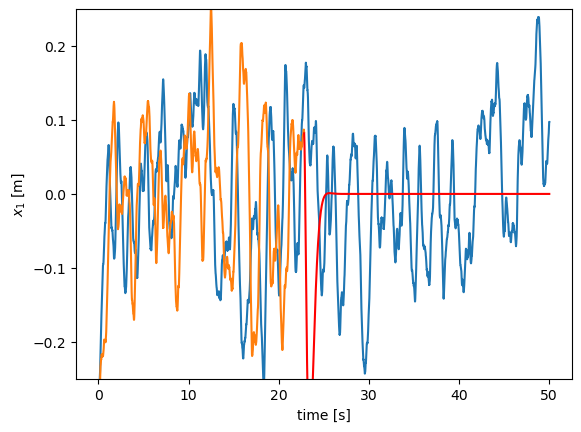

In [713]:
# array for trajectories
x_array = []
u_array = []
N = 5000

num_traj = 2
np.random.seed(6)
xbar = np.random.normal(size=(4,1))

t_controller1 = [[0] for i in range(num_traj)]
t_controller2 = [[] for i in range(num_traj)]

for i in range(num_traj):
    x = np.zeros((4,N+1))
    u = np.zeros((1,N))
    x[:,0] = xbar[0:,0]
    for t in range(N):
        v = np.random.choice([-1,1],size = (1,1))
        x_controller1 = np.array([x[0,t:t+1],np.mod(x[1,t:t+1]+np.pi,2*np.pi)-np.pi,x[2,t:t+1],x[3,t:t+1]]) #choose the right point for the linearization of the first controller modulo 2\pi
        x_controller2 = np.array([x[0,t:t+1],np.mod(x[1,t:t+1],2*np.pi)-np.pi,x[2,t:t+1],x[3,t:t+1]]) #choose the right point for the linearization of the second controller modulo 2\pi
        if x_controller2.T @P2 @ x_controller2 <= 0.02:
            u[:,t:t+1] = K2@np.vstack([np.ones((1,1)),x_controller2])
            t_controller2[i].append(t+1)
        else:
            u[:,t:t+1] = K1@np.vstack([np.ones((1,1)),x_controller1]) + np.sqrt(SigmaV)*v
            t_controller1[i].append(t+1)
        x[:,t+1] = F(x[:,t],u[:,t])
    x_array += [x]
    u_array += [u]
    
fig1, ax1 = plt.subplots()
time = np.linspace(0,N*h,N+1)
for i in range(num_traj):
    x = x_array[i]
    ax1.plot(time[t_controller1[i]],x[1,t_controller1[i]])
    ax1.plot(time[t_controller2[i]],x[1,t_controller2[i]],'r')


ax1.set_ylim([-1.1*np.pi,1.1*np.pi])
ax1.set_xlabel('time [s]')
ax1.set_ylabel('$x_2$ [rad]')
fig1.show()

fig2, ax2 = plt.subplots()
for i in range(num_traj):
    x = x_array[i]
    ax2.plot(time[t_controller1[i]],x[0,t_controller1[i]])
    ax2.plot(time[t_controller2[i]],x[0,t_controller2[i]],'r')


ax2.set_ylim([-0.25,0.25])
ax2.set_xlabel('time [s]')
ax2.set_ylabel('$x_1$ [m]')
fig2.show()